# EDS 296 Homework 2 Geospatial Analysis
Author: Haylee Oyler

Github repo: https://github.com/haylee360/eds296-hw2


In [1]:
# Import packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import intake

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Convert the catalog to a df for easier access
cat_df = catalog.df

I have expand my area of interest from last week from the Congo Basin to the larger African Continent. I'll use the same two models that are well suited to documenting climate changes in that region: GFDL-ESM4 and INM-CM5-0. These are the Institute for Numerical Mathematics (INM) climate model version 5 generation 0 and the Geophysical Fluid Dynamics Laboratory earth systems model 4.

I will be changing which variable I look at. Last time, I was interested in precipitation, but now I will be looking at surface air temperature (tas).

Similar to last time, I will be using the historical model and the `ssp370` projection. 

In [ ]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: Selecting CMIP for historical and ScenarioMIP for future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Models selected earlier
source_id = ['GFDL-ESM4' ,'INM-CM5-0']

# experiment_id: I chose the historical data and the ssp370 projection as my two time experimental configurations
experiment_ids = ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

# member_id: Changed the ensemble member here because there was more data available
member_id = 'r1i1p1f1'

# table_id: Selecting monthly atmospheric data, which is the table that precipitation is stored in. 
table_id = 'Amon' 

# variable_id:  surface air temperature
variable_id = 'tas' 

In [4]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, source_id=source_id, 
                     experiment_id=experiment_ids, table_id=table_id, variable_id=variable_id,
                     member_id=member_id)

# Display data frame associated with results
display(res.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp245,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
1,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
2,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp126,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
3,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/NOAA-GFDL/GFD...,NaN,20180701
4,CMIP,INM,INM-CM5-0,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/INM/INM-CM5-0/histor...,NaN,20190610
5,ScenarioMIP,INM,INM-CM5-0,ssp370,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190618
6,ScenarioMIP,INM,INM-CM5-0,ssp245,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190619
7,ScenarioMIP,INM,INM-CM5-0,ssp126,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190619
8,ScenarioMIP,INM,INM-CM5-0,ssp585,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/ScenarioMIP/INM/INM-CM5-0...,NaN,20190724
9,CMIP,NOAA-GFDL,GFDL-ESM4,historical,r1i1p1f1,Amon,tas,gr1,s3://cmip6-pds/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/...,NaN,20190726


### Model Selection and Cleaning

In [5]:
# Read in the historical data file for INM
hist_inm = xr.open_zarr(res.df['zstore'][4], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_inm = xr.open_zarr(res.df['zstore'][5], storage_options={'anon': True})

# Read in the historical data file for GFDL
hist_gfdl = xr.open_zarr(res.df['zstore'][9], storage_options={'anon': True})

# Read in the SSP370 data file
ssp370_gfdl = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True})

In [7]:
# Concatenate historical and future projections for INM
inm = xr.concat([hist_inm, ssp370_inm], dim="time")

# Concatenate historical and future projections for GFDL
gfdl = xr.concat([hist_gfdl, ssp370_gfdl], dim="time")

In [ ]:
# Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

## Area of Interest: Africa

Last assignment, I looked at precipitation changes in the Congo Basin of West Africa. I've decided to expand my Area of interest to include all of Africa. The Congo Basin is home to one of the largest rainforests in the world and understanding how carbon storage and other biogeochemical fluxes will change under the influence of climate change is crucial. In addition to tropical forests, there is also the Sahara dessert, large areas of temperate savannah and deciduous woodlands. Previousy, I had examined fluxes in precipitation with climate change. Now, I will explore how surface air temperature will change. Both temperature and precipitation are crucial factors that influence how these different biomes are operating as either a carbon sink or source.. Processes and forces like photosynthesis, land use change, fire, and more can all affect carbon dynamics in the region. 

### Time Periods

I will look at a historical period of 1925 to 2025 and a future period of 2025 to 2125.

In [ ]:
# Region of interest
# [lon_min, lon_max, lat_min, lat_max]
region = [-22, 55, -37, 40]

# Time periods of interest
per_early = [1925, 2025]
per_late = [2026, 2125]

# Fix datetime format
inm['time'] = inm.time.astype('datetime64[ns]')
gfdl['time'] = gfdl.time.astype('datetime64[ns]')

# Sort by time for filtering later on
inm = inm.sortby('time')
gfdl = gfdl.sortby('time')

In [17]:
# Slice the data to the time periods
# INM historical
inm_hist = inm.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# INM future
inm_fut = inm.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))
# GFDL historical
gfdl_hist = gfdl.sel(time=slice(str(per_early[0])+"-01-01", str(per_early[1])+"-12-31"))
# GFDL future
gfdl_fut = gfdl.sel(time=slice(str(per_late[0])+"-01-01", str(per_late[1])+"-12-31"))

In [39]:
# Calculate the annual mean tas for each model and extract values
# INM historical
inm_hist_mean = inm_hist.mean(dim="time") - 273.15
inm_hist_mean_val = inm_hist_mean.tas.values

# INM future
inm_fut_mean = inm_fut.mean(dim="time") - 273.15
inm_fut_mean_val = inm_fut_mean.tas.values

# GFDL historical
gfdl_hist_mean = gfdl_hist.mean(dim="time") - 273.15
gfdl_hist_mean_val = gfdl_hist_mean.tas.values

# GFDL future
gfdl_fut_mean = gfdl_fut.mean(dim="time") - 273.15
gfdl_fut_mean_val = gfdl_fut_mean.tas.values


## Mapping

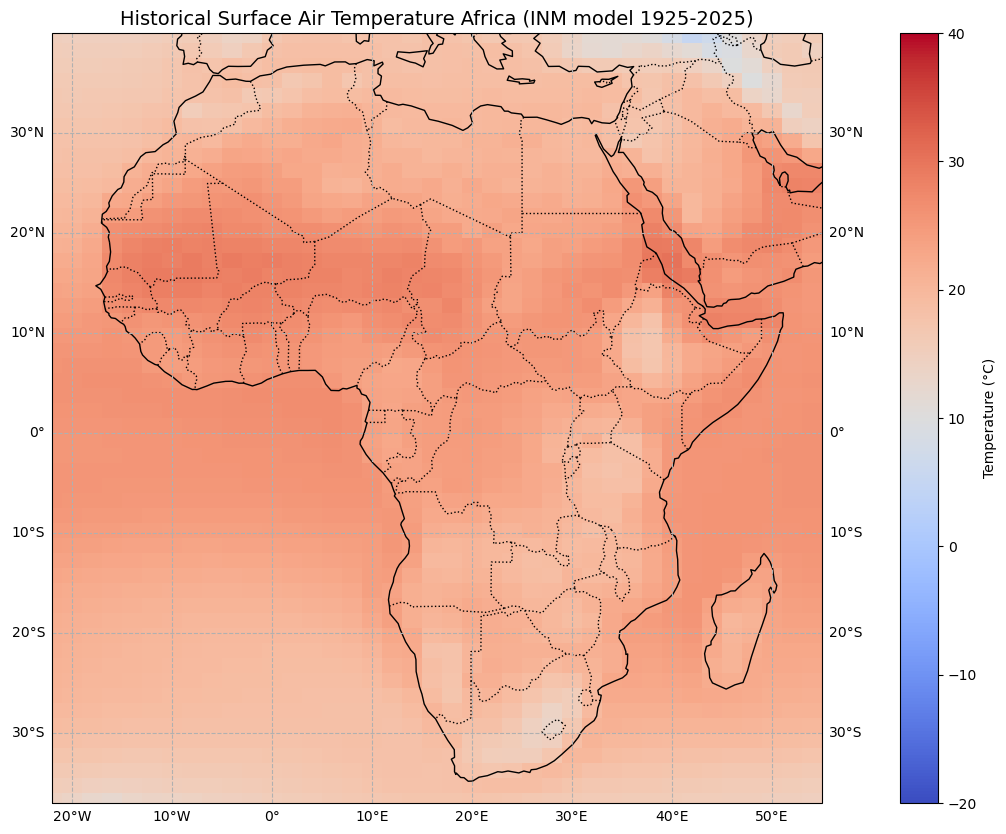

In [53]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(inm_hist_mean.lon, inm_hist_mean.lat, inm_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-20, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Historical Surface Air Temperature Africa (INM model 1925-2025)", fontsize= 14)
plt.show()

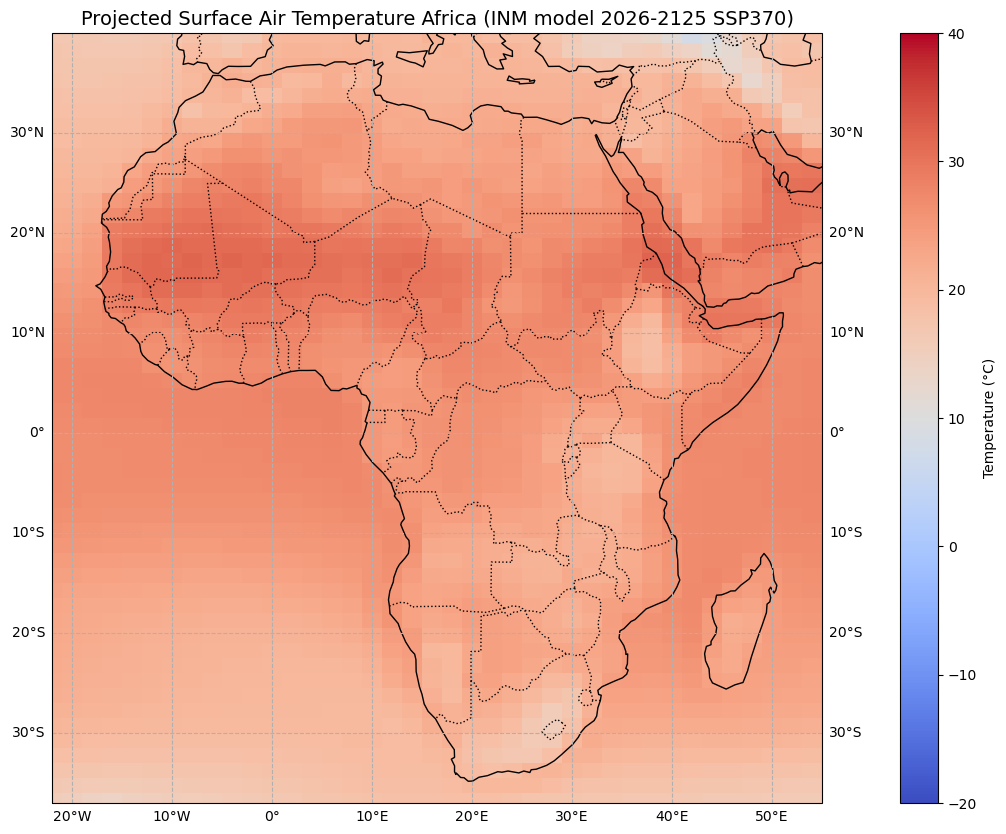

In [54]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(inm_fut_mean.lon, inm_fut_mean.lat, inm_fut_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-20, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Projected Surface Air Temperature Africa (INM model 2026-2125 SSP370)", fontsize= 14)
plt.show()

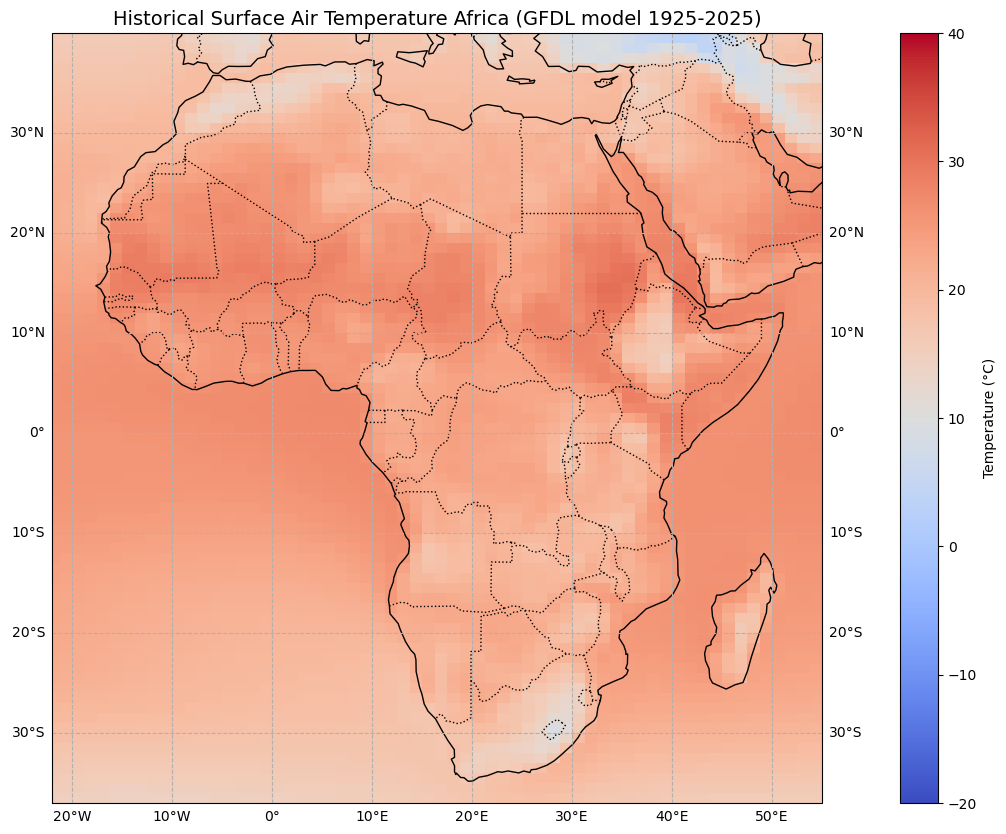

In [55]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(gfdl_hist_mean.lon, gfdl_hist_mean.lat, gfdl_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-20, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Historical Surface Air Temperature Africa (GFDL model 1925-2025)", fontsize= 14)
plt.show()

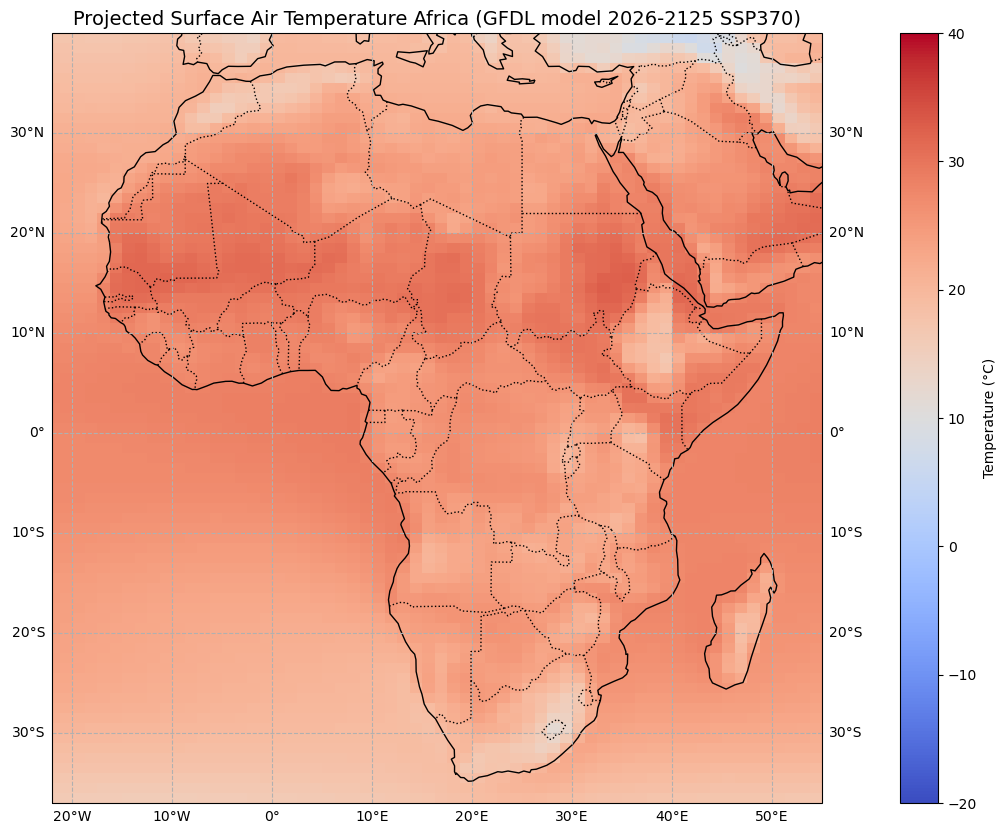

In [56]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(gfdl_fut_mean.lon, gfdl_fut_mean.lat, gfdl_fut_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-20, vmax=40)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Projected Surface Air Temperature Africa (GFDL model 2026-2125 SSP370)", fontsize= 14)
plt.show()

## Difference in Averages

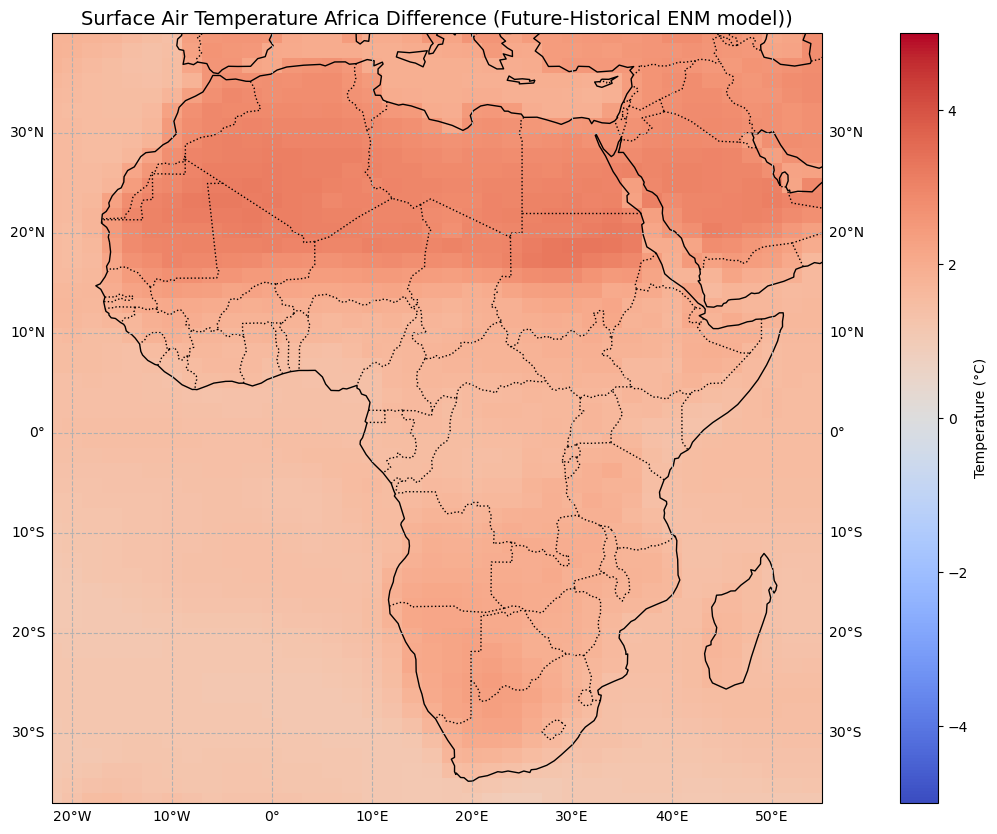

In [ ]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(inm_fut_mean.lon, inm_fut_mean.lat, 
                     inm_fut_mean_val - inm_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Surface Air Temperature Africa Difference (Future-Historical ENM model))", fontsize= 14)
plt.show()

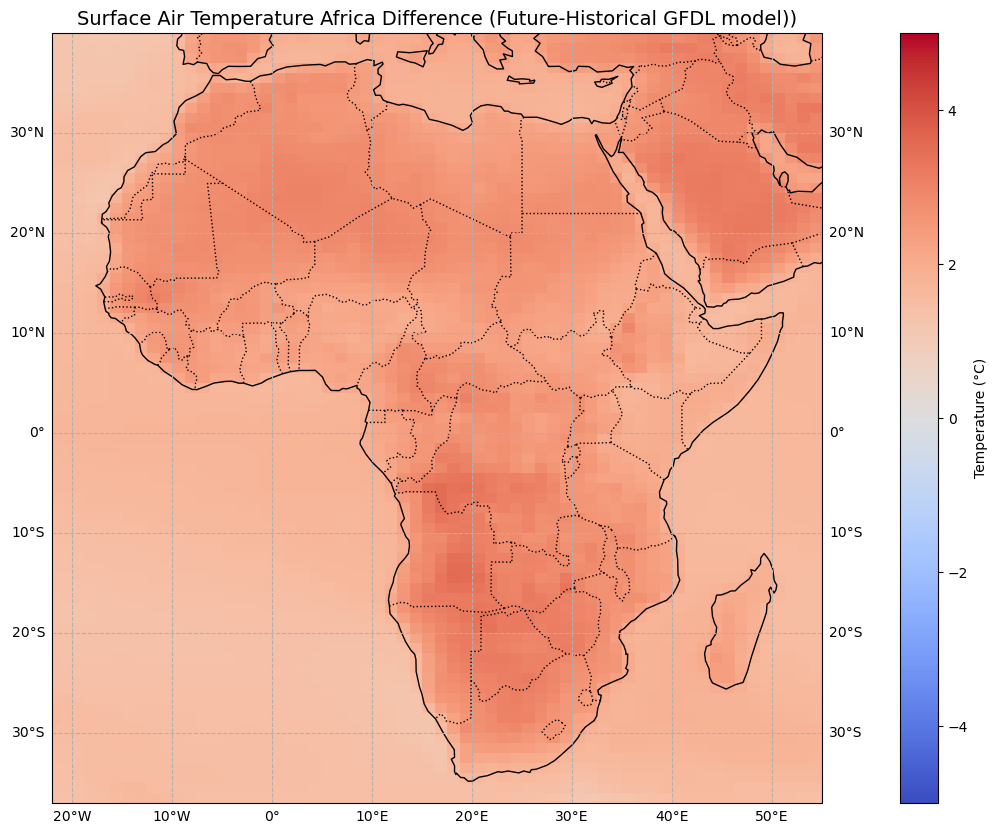

In [49]:
# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(gfdl_fut_mean.lon, gfdl_fut_mean.lat, 
                     gfdl_fut_mean_val - gfdl_hist_mean_val, 
                     transform=map, cmap="coolwarm", vmin=-5, vmax=5)

# Set spatial extent of plot
ax.set_extent(region, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Surface Air Temperature Africa Difference (Future-Historical GFDL model))", fontsize= 14)
plt.show()

### Conclusion

